This is example for query OTT Parsivel_2 data from our lab
==========================================================


In [1]:
import influxdb_client, os, time
from datetime import datetime, timedelta, timezone
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import SYNCHRONOUS

token = "fP-GBq8Z1wZE7iW8qFBuxVy-ArVP9TqVec0naJ77XLECiwSr82aRXqvo3ylXZqU_2ad2vxWGcMoMbl3PXqAZ7A=="
server_url = "http://140.112.12.62:8086"
client = InfluxDBClient(url=server_url, token=token)
query_api = client.query_api()

### Query raw data of DSD. (number-diameter)
In this block. We used `query_api.query()` function.  
Return a list `FluxTable` wrapped into a `TableList`

In [2]:
import numpy as np
import matplotlib.pyplot as plt

query = 'from(bucket: "OTT_Parsivel_2")\
    |> range(start: -1d)\
    |> filter(fn:(r) => r._measurement == "raw_particle")\
    |> drop(columns: ["_start", "_stop"])'

result = query_api.query(org="NTUCE", query = query)
## Return type of query_api.query is a TableList object

### Structure of TableList
`TableList` is basically a list of `FluxTable` with additional features.  
`FluxTable` is a iterator about `FluxRecord` object with additional info.  
`FluxRecord` is a dict like object represent one single record point with some additional features.

In [3]:
print(f'query() return a {type(result).__name__} object')
print(f'Inside TableList object, there are {len(result)} of {type(result[0]).__name__} objects')
print(f'In the first FluxTable object, there are {len(result[0].records)} of {type(result[0].records[0]).__name__} objects')
print(f'In the first FluxRecord object, there is a dict represent the data point.\nLike this: {result[0].records[0].values}')

query() return a TableList object


IndexError: list index out of range

### Process TableList object
We can do several process to TableList object.  
- Parse to list of dict_value.
- Parse to .json formatted string.
- Process by yourself.

### Parse to list of dict_value
We can turn `TableList` to list of `dict_value`.  
But it lost the column name.
So you better know which column you want to get at the beginning.

In [99]:
## Parse TableList object to a list of dict_values object (like a set)
result_dict_value = result.to_values(columns=['_time', '_field', '_value', 'Diameter Class', 'Speed Class'])

## To make list of dict_values object to a list
result_list = [list(dict_value) for dict_value in result_dict_value]

## Print the first data point
print(f'First data point: {result_list[0]}')
print(f'Shape of parsed list: {np.shape(result_list)}')


First data point: [datetime.datetime(2023, 3, 27, 19, 30, 50, tzinfo=tzutc()), 'Number', 1, '10', '14']
Shape of parsed list: (15550, 5)


### Parse to .json object
This is the most convenient way to process `TableList`.  
But it will take more time and memory to process.  
And initially it's a str formatted in json format.

In [111]:
import json

## Parse TableList object to .json object
result_str = result.to_json()
print(f'Type of return of to_json() {type(result_str)}')
print(f'Char num of .json like str object: {len(result_str)}')

## Write .json like str object to a .json file
with open('result/result.json', 'w') as f:
    f.write(result_str)
    
## Turn .json like str object to a .json object
result_json = json.loads(result_str)
key_diameter = 'Diameter Class'
key_speed = 'Speed Class'
key_value = '_value'
print(f'First data point json object:\nDiameter: {result_json[0][key_diameter]}\nSpeed: {result_json[0][key_speed]}\nNumber: {result_json[0][key_value]}')

Type of return of to_json() <class 'str'>
Char num of .json like str object: 3437204
First data point json object:
Diameter: 10
Speed: 14
Number: 1


### Process by yourself
You can process `TableList` object by yourself.  
In this example, we query DSD data.  
DSD is 2-dimension data. 1st dimension is speed, 2nd `dimension` is `diameter`.  
And the value is the number of particles in this bin.  

Note that in a single `FluxTable`. All records have the same **tags** and **fields**.  
So we can use the first record to get the **tags**.  
Use tag information to determine where to store the number of particle data.  

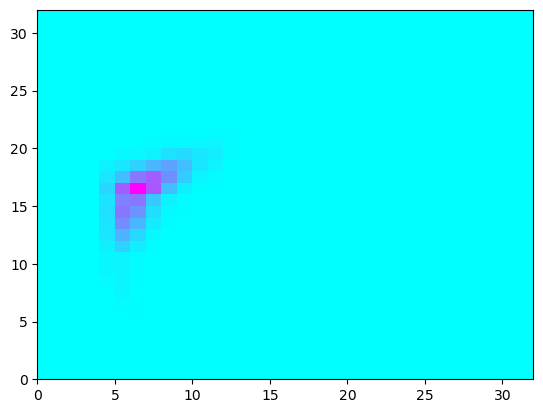

In [110]:
particle_count_self = np.zeros((32, 32))
for table in result:
    diame_class = int(table.records[0].values["Diameter Class"])
    speed_class = int(table.records[0].values["Speed Class"])
    for record in table.records:
        particle_count_self[speed_class, diame_class] += record.get_value()

plt.figure()
plt.pcolormesh(particle_count_self, cmap='cool')
plt.show()

### Plot the same DSD data using result_list

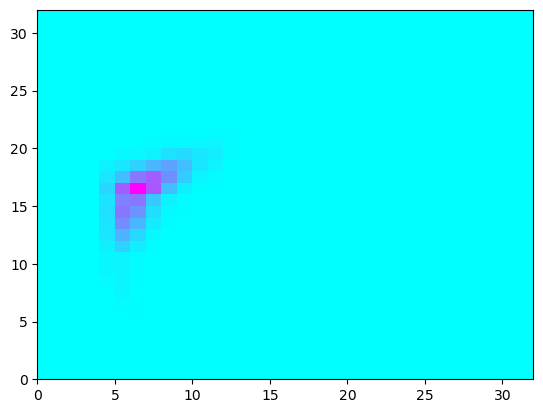

In [113]:
particle_count_list = np.zeros((32, 32))

for i in range(len(result_list)):
    particle_count_list[int(result_list[i][4]), int(result_list[i][3])] += result_list[i][2]

plt.figure()
plt.pcolormesh(particle_count_list, cmap='cool')
plt.show()


### Plot the same DSD data using result_json

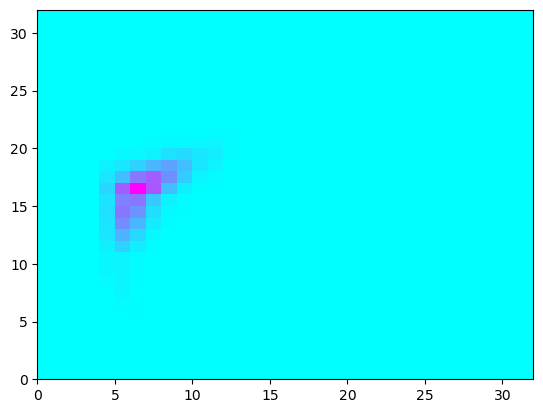

In [ ]:
particle_count_json = np.zeros((32, 32))

key_diameter = 'Diameter Class'
key_speed = 'Speed Class'
key_value = '_value'
for i in range(len(result_json)):
    particle_count_json[int(result_json[i][key_speed]), int(result_json[i][key_diameter])] += result_json[i][key_value]

plt.figure()
plt.pcolormesh(particle_count_json, cmap='inferno')
plt.show()